# Check gpu

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3979368916779747533
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2685000356376970309
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4241301228643050830
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22759661952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16651969512539042971
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:42:00.0, compute capability: 7.5"
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Roberta

# get data

In [4]:
import nest_asyncio
import sys
from green_mood_tracker.twint_class import TWINT
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download
from green_mood_tracker.training_data import get_raw_data_notebook

In [5]:
raw_data = get_raw_data_notebook()

/home/hamish/.virtualenvs/henry2/lib/python3.6/site-packages/green_mood_tracker/training_data.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment140_final['source'] = 'sentiment140'


In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hamish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
from green_mood_tracker.data_cleaning import clean
raw_data = get_raw_data_notebook()
raw_data_clean = clean(raw_data,'text')
raw_data_clean.head()

[nltk_data] Downloading package wordnet to /home/hamish/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/hamish/.virtualenvs/henry2/lib/python3.6/site-packages/green_mood_tracker/training_data.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment140_final['source'] = 'sentiment140'


,id,text,polarity,source
0,1467933112,angel going miss athlete weekend,0.0,sts_gold
1,2323395086,look though shaq getting traded cleveland play...,0.0,sts_gold
2,1467968979,april th isnt coming soon enough,0.0,sts_gold
3,1990283756,drinking mcdonalds coffee understanding someon...,0.0,sts_gold
4,1988884918,dissapointed taylor swift doesnt twitter,0.0,sts_gold


In [35]:
raw_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36472 entries, 0 to 4541
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        36472 non-null  object
 1   text      36472 non-null  object
 2   polarity  36472 non-null  int64 
 3   source    36472 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


In [38]:
raw_data_clean[raw_data_clean['source']=='twitter_corpus'].polarity.value_counts()

0.0    572
Name: polarity, dtype: int64

In [9]:
raw_data_clean = raw_data_clean[raw_data_clean['polarity']!=1]

In [10]:
data_sample = raw_data_clean[raw_data_clean['source']!='sentiment140']

In [11]:
#data_sample = raw_data_clean.sample(n=100_000,random_state=0).reset_index()
#data_sample.head()

In [12]:
data_sample['polarity'] = data_sample.polarity.map({2:1,0:0})
data_sample.head()

,id,text,polarity,source
0,1467933112,angel going miss athlete weekend,0.0,sts_gold
1,2323395086,look though shaq getting traded cleveland play...,0.0,sts_gold
2,1467968979,april th isnt coming soon enough,0.0,sts_gold
3,1990283756,drinking mcdonalds coffee understanding someon...,0.0,sts_gold
4,1988884918,dissapointed taylor swift doesnt twitter,0.0,sts_gold


In [13]:
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21592 entries, 0 to 3951
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        21592 non-null  object
 1   text      21592 non-null  object
 2   polarity  21592 non-null  int64 
 3   source    21592 non-null  object
dtypes: int64(1), object(3)
memory usage: 843.4+ KB


In [14]:
data_sample.polarity.value_counts()

1    10836
0    10756
Name: polarity, dtype: int64

In [15]:
# data_sample['text'] = data_sample.text.apply((lambda x: x.split()))

In [16]:
from sklearn.model_selection import train_test_split

X = data_sample.text
y = data_sample.polarity

sentence_train, sentence_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 0)

In [17]:
sentence_train, sentence_val, y_train, y_val = train_test_split(sentence_train, y_train, test_size=0.3, random_state = 0)

In [18]:
#!pip install absl-py --quiet

In [19]:
#!pip install tensorflow-datasets --quiet

In [20]:
#!pip install transformers --quiet

# build roberta

In [21]:
import pandas as pd
# Recommended tensorflow version is <= 2.1.0, otherwise F1 score function breaks
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
from transformers import TFRobertaForSequenceClassification, TFRobertaModel
from transformers import RobertaTokenizer
from transformers import AdamWeightDecay
import os

In [22]:
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [23]:
max_length = 50

# the recommended batches size for BERT are 32,64 ... however on this dataset we are overfitting quite fast
# and smaller batches work like a regularization.
# You might play with adding another dropout layer instead.

batch_size = 128

In [24]:
def convert_example_to_feature(review):
    # combine step for tokenization, WordPiece vector mapping and will
    # add also special tokens and truncate reviews longer than our max length
    return roberta_tokenizer.encode_plus(review,
                                 add_special_tokens=True,  # add [CLS], [SEP]
                                 max_length=max_length,  # max length of the text that can go to RoBERTa
                                 truncation=True,
                                 padding= 'max_length',  # add [PAD] tokens at the end of sentence
                                 return_attention_mask=True,  # add attention mask to not focus on pad tokens
                                 )

In [25]:
# map to the expected input to TFRobertaForSequenceClassification, see here
def map_example_to_dict(input_ids, attention_masks, label):
    return {
      "input_ids": input_ids,
      "attention_mask": attention_masks,
           }, label

In [26]:
def encode_examples(ds, limit=-1):
    # Prepare Input list
    input_ids_list = []
    attention_mask_list = []
    label_list = []

    if (limit > 0):
        ds = ds.take(limit)

    for review, label in tfds.as_numpy(ds):
        bert_input = convert_example_to_feature(review.decode())
        input_ids_list.append(bert_input['input_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])

    return tf.data.Dataset.from_tensor_slices((input_ids_list,
                                               attention_mask_list,
                                               label_list)).map(map_example_to_dict)

In [27]:
training_sentences_modified = tf.data.Dataset.from_tensor_slices((sentence_train,
                                                                  y_train))

val_sentences_modified = tf.data.Dataset.from_tensor_slices((sentence_val,
                                                                 y_val))

testing_sentences_modified = tf.data.Dataset.from_tensor_slices((sentence_test,
                                                                 y_test))

ds_train_encoded = encode_examples(training_sentences_modified).shuffle(10000).batch(batch_size)
ds_val_encoded = encode_examples(val_sentences_modified).batch(batch_size)
ds_test_encoded = encode_examples(testing_sentences_modified).batch(batch_size)

In [28]:
learning_rate = 7e-5
number_of_epochs = 10

In [46]:
model = TFRobertaForSequenceClassification.from_pretrained("roberta-base")
optimizer = AdamWeightDecay(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaForSequenceClassification: ['lm_head']
- This IS expected if you are initializing TFRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3,restore_best_weights=True,monitor='val_accuracy')
history = model.fit(ds_train_encoded, epochs=number_of_epochs,
          validation_data=ds_val_encoded, callbacks=[es])

Epoch 1/15
166/166 [==============================] - 32s 191ms/step - loss: 0.3846 - accuracy: 0.8377 - val_loss: 0.2800 - val_accuracy: 0.8836
Epoch 2/15
166/166 [==============================] - 30s 182ms/step - loss: 0.2680 - accuracy: 0.8963 - val_loss: 0.2909 - val_accuracy: 0.8948
Epoch 3/15
166/166 [==============================] - 30s 182ms/step - loss: 0.1998 - accuracy: 0.9288 - val_loss: 0.3126 - val_accuracy: 0.8862
Epoch 4/15
166/166 [==============================] - 31s 184ms/step - loss: 0.1731 - accuracy: 0.9383 - val_loss: 0.3016 - val_accuracy: 0.8986
Epoch 5/15
166/166 [==============================] - 31s 185ms/step - loss: 0.1333 - accuracy: 0.9542 - val_loss: 0.3224 - val_accuracy: 0.8831
Epoch 6/15
166/166 [==============================] - 31s 185ms/step - loss: 0.1271 - accuracy: 0.9584 - val_loss: 0.3722 - val_accuracy: 0.8873
Epoch 7/15
166/166 [==============================] - 31s 187ms/step - loss: 0.0862 - accuracy: 0.9722 - val_loss: 0.3467 - val_ac

In [32]:
#from tensorflow.keras import layers, models

#def add_last_layers(model):
#    base_model = set_nontrainable_layers(model)
#    flatten_layer = layers.Flatten()
#    dense_layer = layers.Dense(500, activation='relu')
#    prediction_layer = layers.Dense(3, activation='softmax')
    
    
#    model = models.Sequential([
#        model,
#        flatten_layer,
#        dense_layer,
#        prediction_layer
#    ])
    


In [39]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

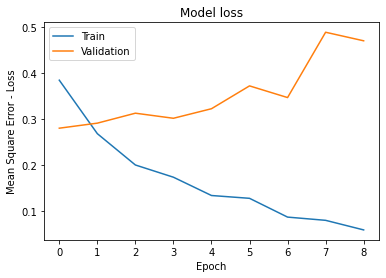

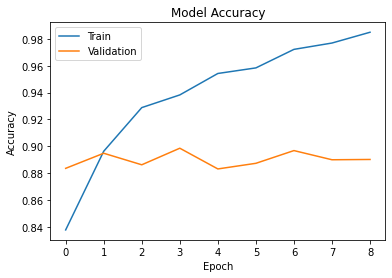

In [48]:
plot_loss(history)

In [49]:
model.evaluate(ds_test_encoded)

102/102 [==============================] - 6s 58ms/step - loss: 0.3135 - accuracy: 0.8919


[0.31353265047073364, 0.8919419646263123]

In [37]:

from tensorflow.keras import models

# Let's say that you have a `model`
# You can save it :
models.save_model(model, 'model_roBERTa_binary_3')

# and you can load it somewhere else :
#loaded_model = models.load_model('my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_roBERTa_binary_3/assets


In [38]:
# class ModelMetrics(tf.keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.count_n = 1

#     def on_epoch_end(self, batch, logs={}):
        
#         os.mkdir('/create/directory/for/model/' + str(self.count_n))
#         self.model.save_pretrained('/save/trained/model/here/' + str(self.count_n)) # this folder address should match with folder we created above
        
#         y_val_pred = tf.nn.softmax(self.model.predict(ds_test_encoded))
#         y_pred_argmax = tf.math.argmax(y_val_pred, axis=1)
#         testing_copy = testing_sentences.copy()
#         testing_copy['predicted'] = y_pred_argmax
#         f1_s = f1_score(testing_sentences['label'], testing_copy['predicted'])
#         print('\n f1 score is :', f1_s)
#         self.count_n += 1

# metrics = ModelMetrics()

In [29]:
!pip install -q -U keras-tuner
import kerastuner as kt

You should consider upgrading via the '/home/hamish/.virtualenvs/henry2/bin/python -m pip install --upgrade pip' command.


In [30]:
def model_builder(hp):
    hp_learning_rate = hp.Choice('learning_rate', values = [7e-5, 1e-5, 12e-5])
    hp_epsilon = hp.Choice('epsilon', values = [1e-08, 1e-07, 1e-06])
    hp_beta_1 = hp.Choice('beta_1', values = [0.91, 0.9, 0.85])
    hp_decay = hp.Choice('weight_decay', values = [0., 0.001, 0.0015])
    model = TFRobertaForSequenceClassification.from_pretrained("roberta-base")
    optimizer = AdamWeightDecay(learning_rate= hp_learning_rate, epsilon=hp_epsilon,beta_1=hp_beta_1,weight_decay_rate=hp_decay)

    # we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
    return model

In [31]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'roberta-tuning')

INFO:tensorflow:Reloading Oracle from existing project my_dir/roberta-tuning/oracle.json


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaForSequenceClassification: ['lm_head']
- This IS expected if you are initializing TFRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


INFO:tensorflow:Reloading Tuner from my_dir/roberta-tuning/tuner0.json


In [32]:
import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
      def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=3,restore_best_weights=True,monitor='val_accuracy')
tuner.search(ds_train_encoded, epochs = 10, validation_data = ds_val_encoded, callbacks = [es,ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal 
learning rate is {best_hps.get('learning_rate')} and epsilon {best_hps.get('epsilon')} and beta {best_hps.get('beta_1')} and decay {best_hps.get('weight_decay')} .
""")


Trial 12 Complete [00h 07m 50s]
val_accuracy: 0.8970840573310852

Best val_accuracy So Far: 0.9025728702545166
Total elapsed time: 01h 00m 16s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal 
learning rate is 1e-05 and epsilon 1e-08 and beta 0.9 and decay 0.001 .



In [37]:
model = tuner.hypermodel.build(best_hps)
model.fit(ds_train_encoded, epochs = 10, validation_data = ds_val_encoded)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaForSequenceClassification: ['lm_head']
- This IS expected if you are initializing TFRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
107/107 [==============================] - 58s 540ms/step - loss: 0.4207 - accuracy: 0.8041 - val_loss: 0.2755 - val_accuracy: 0.8933
Epoch 2/10
107/107 [==============================] - 56s 526ms/step - loss: 0.2640 - accuracy: 0.8938 - val_loss: 0.2582 - val_accuracy: 0.8979
Epoch 3/10
107/107 [==============================] - 57s 529ms/step - loss: 0.2306 - accuracy: 0.9105 - val_loss: 0.2877 - val_accuracy: 0.8983
Epoch 4/10
107/107 [==============================] - 57s 529ms/step - loss: 0.2057 - accuracy: 0.9219 - val_loss: 0.2788 - val_accuracy: 0.8979
Epoch 5/10
107/107 [==============================] - 57s 529ms/step - loss: 0.1773 - accuracy: 0.9335 - val_loss: 0.2698 - val_accuracy: 0.9034
Epoch 6/10
107/107 [==============================] - 56s 528ms/step - loss: 0.1622 - accuracy: 0.9420 - val_loss: 0.2901 - val_accuracy: 0.9017
Epoch 7/10
107/107 [==============================] - 56s 528ms/step - loss: 0.1339 - accuracy: 0.9552 - val_loss: 0.2837 - val_ac

In [38]:
model.evaluate(ds_test_encoded)

17/17 [==============================] - 3s 151ms/step - loss: 0.3372 - accuracy: 0.9009


[0.3371899425983429, 0.9009259343147278]

In [40]:
from tensorflow.keras import models
models.save_model(model, '../raw_data/models/model_roBERTa_lr1e-05epsilon1e-08beta0.9decay0.001')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../raw_data/models/model_roBERTa_lr1e-05epsilon1e-08beta0.9decay0.001/assets


In [ ]:
Trial 30 Complete [00h 03m 39s]
val_accuracy: 0.9009922742843628

Best val_accuracy So Far: 0.9023153185844421
Total elapsed time: 00h 59m 41s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal 
learning rate is 1e-05 and epsilon 1e-06 and beta 0.9 and decay 0.001 